In [44]:
%load_ext autoreload
%autoreload 2

import numpy as np
from utils.data_helper import *
from utils.data import *
from utils.stats import *
from utils.performance import *
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from account import Binance
import pandas as pd
import numpy as np
import warnings
from strategy_v3.Strategy import *
from strategy_v3.Executor import ExecutorBinance, ExecutorBacktest
from strategy_v3.ExecuteSetup import *
from strategy_v3.ExecuteSetup.StrategyFactory import StrategyFactory
from strategy_v3.DataLoader import DataLoaderBinance
from tqdm import tqdm
from zoneinfo import ZoneInfo
from datetime import datetime, timedelta
import seaborn as sns


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 30)
pd.options.display.float_format = "{:,.4f}".format
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Grid Trading Logic (Arithmetic)

### For each time interval, iterate thru below steps

1. check if status is idle (i.e. no outstanding grid orders) and hurst exponent to see if this indicates mean-reverting trends

2. If both yes for above, place grid orders via LIMIT ORDER

- num orders   = grid_size * 2
- grid spacing = historical volatility * vol scale
- stop loss    = historical volatility * vol scale * vol_stoploss_scale

3. fill the orders using high and low (backtest mode only)

4. check if status neutral (i.e. have filled grid orders but positions are neutral). If yes, cancel all orders

5. check if current price triggers stop-loss. If yes, cancel all orders and close out position via MARKET ORDER.

## Strategy logging

2024-02-27: Attempt to use rolling average metrics based on looking back 2 * half life interval. Replace vol with half-life vol and center price from spot to half-life SMA close

-  Tested BTCFDUSD on 15days. original cum returns is 6% whereas new change is 3% only

2024-02-28: Attempt to use momentum order when hurst exponent is >= 0.6 and use extra momentum filters (Spot > T-5 > T-10) to put the momentum grid orders.

-  Tested BTCFDUSD. this added more return on original strategy, because this is mutually exclusive with mean reverting orders, this enhance return during non-mean-reverting periods 

2024-02-29: Changed the momentum filters to be Spot > T-5 High and T-5 Low > T-10 High to be more conservative

- Exectue refresh time updated from 30s to 1m to avoid small price volatolity to trigger the stoploss

- For backtesting, shall we consider the interval high/low if this trigger stop-loss rather than just check close price???

- [BTCFDUSD] Realized returns are now 2% after fixing the fill price

- <b>Follow up: need to use STOP_LOSS_LIMIT for momentum orders</b>, because now all limit buy orders above market price are filled immediately, but we want to avoid that.

2024-03-01: Updated momentum orders to use STOP-LOSS-LIMIT to avoid LIMIT ORDER executed immediately

- Able to split the PnL from momentum orders and mean reverting orders.

- [BTCFDUSD] Realized returns are now 4%

- [SOLFDUSD] started to trade SOLFDUSD (need to change the quantity decision = 2)

- <b>we need to build a server in order to systematically runs for multiple strategies, meanwhile we can also interrupt the model parameters during runtime</b>

2024-03-02: Attempt to build telegram bot 

- trying to explore reduce grid spacing and lookback periods. In backtest, reducing lookback periods generally has better performance

2024-03-03: Still building telegram bot to control the model parameters on the fly by mobile phone

- the backtest filling logic is to aggressive. In reality, the orders aren't filled like what we assumed in backtest. we need to update the backtest filling logic 

2024-03-04: replace volatility from close std to average true return. This is because ATR has considered all interval high and low whereas close std is just a metrics on close price

- add interrupt function to strategy: RUN, PAUSE, TERMINATE, STOP

## TODO

- enhance backtest fill logic, high and low price are likely unfill-able in reality, we need to account for that

- enhance the center price logic for mean-revert order, need to use the mean price in previous periods instead of current price as center price

- enhance telegram to update a set of predefined model parameters (like vol_grid_scale to be 0.1,0.2,0.3....)

- enhance hurst exponent ratio to be shorter time frame (now is 100)

## BackTest Strategy

In [2]:
def backtest_strategy(strategy, start_str:str):
    strategy.load_data(start_str)    
    df = strategy.df.copy()
    with tqdm(total = len(df)) as pbar:
        for _, data in df.iterrows():
            strategy.execute(data)
            pbar.update(1)

    strategy.cancel_all_orders()
    strategy.close_out_positions('close', data['Close'], data['Date'])
    return strategy

In [3]:
strategy1 = StrategyFactory().get('v1')
strategy1.set_data_loder(DataLoaderBinance())
strategy1.set_executor(ExecutorBacktest())
strategy1.logger.setLevel('CRITICAL')      
strategy1.status = STATUS.RUN

In [ ]:
strategy1 = backtest_strategy(strategy1, '5 Days Ago')

In [ ]:
strategy1.summary(True)

# Execute Strategy

Strategy ID - all orders are marked by strategy id

Therefore, all orders / pnl logic are based on same set of orders which isolates from other strategy or previous strategy

If we want to continue previous strategy (either manual exit or error exit), we need to put the same strategy id. so the pnl could be accumlated from last time.

<b>Notes: execute.py runs the actual strategy, below code is just to keep track the strategy status and performance</b>

### Strategy logging:

-   903492 - traded on BTCUSDT for 1.5days. gross pnl is good, but realized that there is 0.1% transaction cost which overwhelme all the PNL

-   v1 - traded on BTCFDUSD - no transaction cost. 
    -  Corrected the definition of price volatility from close.diff.std to close.std and change the vol_grid_scale from 0.4 to 0.2.

    -  Discover that the PnL seems to increase with smaller grid spacing
    
    -  Start using momentum orders

-   SOLFDUSDv1 - traded on SOLFDUSD - no transaction cost.

In [63]:
setup = ExecuteSetup.read_all()
strategy_dict = dict()

In [64]:
for k, v in setup.items():    
    strategy = StrategyFactory().get(k)
    strategy.set_data_loder(DataLoaderBinance())
    strategy.set_executor(ExecutorBinance())
    strategy.set_strategy_id(k, reload=True)    
    if str(type(strategy)) == str(GridArithmeticStrategy):
        strategy_dict[k] = strategy                                  

In [65]:
# for tag in ['v1', 'SOLv1', 'ETHv1']:
#     strategy = strategy_dict[tag]
#     start_date = strategy.start_date
#     start_date = datetime(year=start_date.year, month=start_date.month, day=start_date.day, tzinfo=ZoneInfo("HongKong"))    
#     end_date = datetime.today() - timedelta(1)
#     end_date = datetime(year=end_date.year, month=end_date.month, day=end_date.day, tzinfo=ZoneInfo("HongKong"))
#     strategy.save_pnl_between(start_date, end_date, overwrite=False)

In [70]:
# pnl cutoff as 00:00 HKT
offset = 0
date = datetime.today()
date = datetime(year=date.year, month=date.month, day=date.day, tzinfo=ZoneInfo("HongKong")) - timedelta(days=offset)
date_str = date.strftime('%Y-%m-%d %H:%M:%S%z')
date_str_end = (date + timedelta(days=1)).strftime('%Y-%m-%d %H:%M:%S%z')

In [71]:
for k, v in strategy_dict.items():
    strategy = v
    strategy.load_data(date_str, lookback_end=date_str_end)    
    strategy.summary(True, lastn=20)

,Measure,grid_v1
0,Pnl,-0.7449
1,Trading Fee,0.0000
2,Cumulative Return,0.9998
3,Annualized Return,-0.6436
4,Annualized Volatility,0.0244
5,Annualized Sharpe Ratio,-28.4553
6,Maximum Drawdown,-0.0004


,Measure,grid_SOLv1
0,Pnl,1.6975
1,Trading Fee,0.0000
2,Cumulative Return,1.0017
3,Annualized Return,5.8664
4,Annualized Volatility,0.0902
5,Annualized Sharpe Ratio,64.4673
6,Maximum Drawdown,-0.0007


,Measure,grid_ETHv1
0,Pnl,9.5719
1,Trading Fee,0.0000
2,Cumulative Return,1.0014
3,Annualized Return,4.7258
4,Annualized Volatility,0.0427
5,Annualized Sharpe Ratio,109.4615
6,Maximum Drawdown,0.0000


# Historical PnL

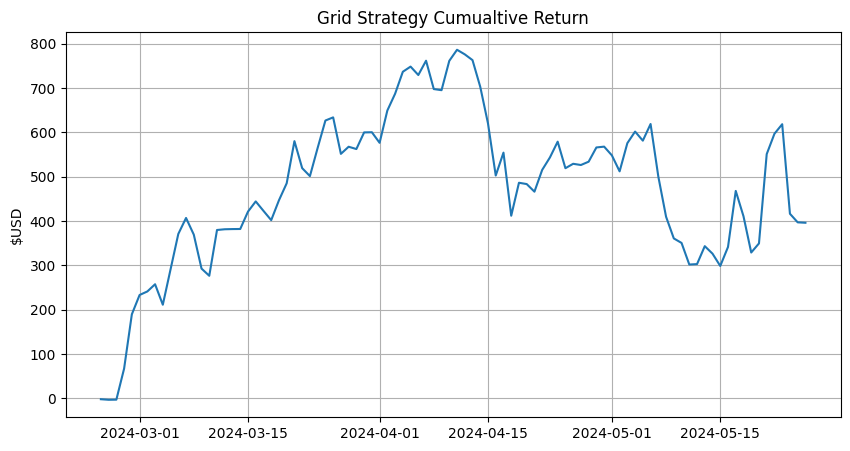

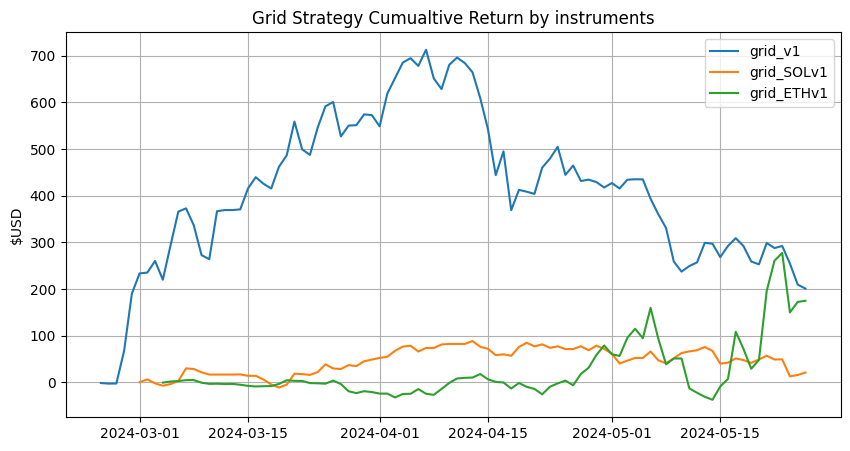

In [60]:
pnl = []
for strategy in strategy_dict.values():
    pnl.append(strategy.get_pnl())

plt.figure(figsize=(10,5))
pnl = pd.concat(pnl)
pnl_all = pnl.groupby(['Date']).sum(numeric_only=True)
pnl_all['pnl_cum'] = pnl_all['pnl'].cumsum()
pnl_all.sum(numeric_only=True)
plt.plot(pnl_all['pnl_cum'])
plt.title('Grid Strategy Cumualtive Return')
plt.grid()
plt.ylabel('$USD')
plt.show()

plt.figure(figsize=(10,5))
pnl_strategy = pnl.groupby(['Date', 'strategy']).sum(numeric_only=True).reset_index()
for s in pnl_strategy['strategy'].unique():
    t = pnl_strategy[pnl_strategy['strategy'] == s]
    t['pnl_cum'] = t['pnl'].cumsum()
    plt.plot(t['Date'], t['pnl_cum'], label=s)

plt.title('Grid Strategy Cumualtive Return by instruments')
plt.legend()
plt.grid()
plt.ylabel('$USD')
plt.show()
